#QuickStart

Pytorch has two primitives to work with data: Dataset and Dataloader (from torch.utils.data). Dataset stores the samples and their corresponding labels, and DataLoader wrasp an iterable around the Dataset.

##Work with data

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch offers domain-specific libraries. For this part takes TorchVision dataset.


He torchvision.datasets module contains Dataset objects for many real-world vision data like CIFAR, COCO ([full list](https://pytorch.org/vision/stable/datasets.html)). In this part, we use the FachionMNIST dataset. Every TorchVision Dataset includes two arguments: transform and target_transform to modify the samples and labels respectively.

In [ ]:
training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [ ]:
batch_size = 64

# Create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
  print(f"Shape of X [N, C, H, W] : {X.shape}")
  print(f"Shape of y : {y.shape} {y.dtype}\n")
  
  break

Shape of X [N, C, H, W] : torch.Size([64, 1, 28, 28])
Shape of y : torch.Size([64]) torch.int64



##Create model

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the $__init__$ function and specify how data will pass throught in the forward function. To accelerate operations in the neurla network, we move it to the GPU if available.

In [ ]:
x, y = next(iter(train_dataloader))

In [ ]:
input_dim = x.shape[2] * x.shape[3]
output_dim = 10 # 10 labels from 0 to 9

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(NeuralNetwork, self).__init__()

    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(input_dim, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, output_dim)
    )
  
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

model = NeuralNetwork(input_dim, output_dim).to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


##Optimizing the Model Parametrs

to train model, we need optimizer and loss function

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-03)

In a single training loop, the model makes predictions on the training dataset (fed to in batches), and backpropagates the prediciton error to adjust the models parametrs

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss : {loss:>7f} [{current:>5d} / {size:>5d}]")

def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size

    print(f"Test Error: \n Accuracy : {(100*correct):>0.1f}%, AVG loss : {test_loss:>8f}\n")


In [ ]:
epochs = 5

for t in range(epochs):
  print(f"Epoch {t+1}\n{'-'*30}")
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
print('Done!')

Epoch 1
------------------------------
loss : 2.280506 [    0 / 60000]
loss : 2.284594 [ 6400 / 60000]
loss : 2.264329 [12800 / 60000]
loss : 2.265496 [19200 / 60000]
loss : 2.258743 [25600 / 60000]
loss : 2.204423 [32000 / 60000]
loss : 2.226278 [38400 / 60000]
loss : 2.184313 [44800 / 60000]
loss : 2.171762 [51200 / 60000]
loss : 2.152176 [57600 / 60000]
Test Error: 
 Accuracy : 44.5%, AVG loss : 2.145025

Epoch 2
------------------------------
loss : 2.135743 [    0 / 60000]
loss : 2.139534 [ 6400 / 60000]
loss : 2.080386 [12800 / 60000]
loss : 2.105754 [19200 / 60000]
loss : 2.057351 [25600 / 60000]
loss : 1.976117 [32000 / 60000]
loss : 2.015294 [38400 / 60000]
loss : 1.931399 [44800 / 60000]
loss : 1.929654 [51200 / 60000]
loss : 1.860475 [57600 / 60000]
Test Error: 
 Accuracy : 59.0%, AVG loss : 1.864009

Epoch 3
------------------------------
loss : 1.877565 [    0 / 60000]
loss : 1.860722 [ 6400 / 60000]
loss : 1.743907 [12800 / 60000]
loss : 1.795765 [19200 / 60000]
loss : 1.

##Saving Models

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


##Loading Models

In [ ]:
model = NeuralNetwork(input_dim, output_dim)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

This model can now be used to make predictions

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [ ]:
model.eval()
x, y = test_data[12][0], test_data[12][1]

with torch.no_grad():
  pred = model(x)
  predicted, actual = classes[pred[0].argmax(0)], classes[y]
  print(f"Predicted '{predicted}', Actual : '{actual}'")

Predicted 'Sneaker', Actual : 'Sneaker'


#Tensors

Tensors are a specialized data structure that are very similar to arrays and matrices. In PyTorch, we use tensors to encode the inputs and outputs of a model, as well as the model's parameters.


Tensors are similar to NumPy's ndarrays, except that tensors can run on GPUs or other hardware accelerators. In fact, tensors NumPy arrays can often share the same underlying memory, elimininating the need to copy data. Tensors are also optimized for automatic differentiation.

In [ ]:
import torch
import numpy as np

In [ ]:
data = [[1, 2], [3, 4]]
x_data = torch.tensor(data)

In [ ]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

In [ ]:
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor : \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor : \n {x_rand} \n")

Ones Tensor : 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor : 
 tensor([[0.2569, 0.6195],
        [0.1104, 0.6221]]) 



In [ ]:
shape = (2, 3, )

rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f'Random Tensor : \n {rand_tensor} \n')
print(f'Ones Tensor : \n {ones_tensor} \n')
print(f'Zeros Tensor : \n {zeros_tensor} \n')

Random Tensor : 
 tensor([[0.1634, 0.4318, 0.7795],
        [0.6111, 0.4979, 0.9466]]) 

Ones Tensor : 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor : 
 tensor([[0., 0., 0.],
        [0., 0., 0.]]) 



##Attributes of a Tensor

In [ ]:
tensor = torch.rand(3, 4)

print(f'Shape of tensor : {tensor.shape}')
print(f'Datatype of tensor : {tensor.dtype}')
print(f'Device tensor is stored on : {tensor.device}')

Shape of tensor : torch.Size([3, 4])
Datatype of tensor : torch.float32
Device tensor is stored on : cpu


In [ ]:
if torch.cuda.is_available():
    tensor = tensor.to("cuda")

In [ ]:
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:,1] = 0
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [ ]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


In [ ]:
# This computes the matrix multiplication between two tensors. y1, y2, y3 will have the same value
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(tensor)
torch.matmul(tensor, tensor.T, out=y3)

tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])

In [ ]:
# This computes the element-wise product. z1, z2, z3 will have the same value
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

In [ ]:
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

12.0 <class 'float'>


#Datasets & Dataloaders

##Loading a Dataset

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that subclass torch.utils.data.Dataset and implement functions specific to the particular data. 

Here is an example of how to load the Fashion-MNIST dataset from TorchVision. Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples. Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.

We load the FashionMNIST Dataset with the following parameters:
* root is the path where the train/test data is stored,
* train specifies training or test dataset,
* download=True downloads the data from the internet if it’s not available at root.
* transform and target_transform specify the feature and label transformations

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [ ]:
training_data = datasets.FashionMNIST(
    root='data', 
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

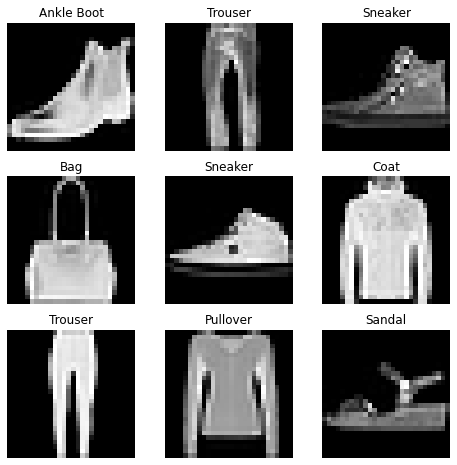

In [ ]:
from matplotlib import is_url
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1, )).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis('off')
  plt.imshow(img.squeeze(), cmap='gray')
plt.show()

##Creating a Custom Dataset for your files

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
  def __init__(self, annotation_file, img_dir, transform=None, target_transform=None):
    self.ing_labels = pd.read_csv(annotation_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.ing_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.ing_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]

    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)

    return image, label

##Preparing your data for training with DataLoaders

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


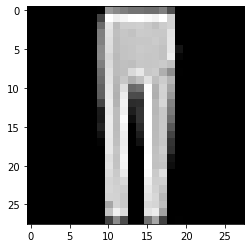

Label: 1


In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html